In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.utils import class_weight

import cirq
import pennylane as qml

import tensorflow as tf


np.random.seed(42)
tf.random.set_seed(42)



In [19]:
def load_and_preprocess_data(file_path):
    """Load and preprocess the full high energy physics dataset"""
    print(f"Loading data from {file_path}")
    
    data = np.load(file_path, allow_pickle=True)
    print(f"Keys in file: {list(data.keys())}")
    
    # Extract training features
    training_dict = data['training_input'].item()
    training_key = list(training_dict.keys())[0]
    X_train = training_dict[training_key]
    
    # Extract test features if available
    if 'test_input' in data:
        test_dict = data['test_input'].item()
        test_key = list(test_dict.keys())[0]
        X_test = test_dict[test_key]
        print(f"Using provided test set with shape: {X_test.shape}")
    else:
        # If no test set, use 20% of training data as test
        split_idx = int(0.8 * len(X_train))
        X_test = X_train[split_idx:]
        X_train = X_train[:split_idx]
        print(f"Created test set with shape: {X_test.shape}")
    
    print(f"Training set shape: {X_train.shape}")
    
    # Create labels using PCA (typical approach for HEP data)
    pca = PCA(n_components=1)
    train_pca = pca.fit_transform(X_train)
    test_pca = pca.transform(X_test)
    
    # Use median as threshold
    threshold = np.median(train_pca)
    y_train = (train_pca > threshold).astype(int).ravel()
    y_test = (test_pca > threshold).astype(int).ravel()
    
    # Print class distribution
    train_signal = np.sum(y_train)
    train_background = len(y_train) - train_signal
    test_signal = np.sum(y_test)
    test_background = len(y_test) - test_signal
    
    print(f"Train set: {train_signal} signal ({train_signal/len(y_train):.1%}), "
          f"{train_background} background ({train_background/len(y_train):.1%})")
    print(f"Test set: {test_signal} signal ({test_signal/len(y_test):.1%}), "
          f"{test_background} background ({test_background/len(y_test):.1%})")
    
    # Compute class weights for training
    class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Scale features for classical model
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Scale features to [0,1] for quantum circuit
    min_max_scaler = MinMaxScaler()
    X_train_quantum = min_max_scaler.fit_transform(X_train_scaled)
    X_test_quantum = min_max_scaler.transform(X_test_scaled)
    
    return (X_train_scaled, X_test_scaled, 
            X_train_quantum, X_test_quantum, 
            y_train, y_test, class_weight_dict)

# Load the data
file_path = './QIS_EXAM_200Events.npz'  # Update with your file path
(X_train, X_test, 
 X_train_quantum, X_test_quantum, 
 y_train, y_test, class_weight_dict) = load_and_preprocess_data(file_path)

Loading data from ./QIS_EXAM_200Events.npz
Keys in file: ['training_input', 'test_input']
Using provided test set with shape: (50, 5)
Training set shape: (50, 5)
Train set: 25 signal (50.0%), 25 background (50.0%)
Test set: 23 signal (46.0%), 27 background (54.0%)


In [21]:
def create_quantum_circuit(n_qubits=8, n_layers=3):
    """Create quantum circuit with PennyLane"""
    # Create quantum device
    dev = qml.device("default.qubit", wires=n_qubits)
    
    # Define quantum circuit
    @qml.qnode(dev)
    def quantum_circuit(features, params):
        # Data encoding
        for i in range(n_qubits):
            if i < len(features):
                qml.RY(features[i] * np.pi, wires=i)
        
        # Variational layers
        for layer in range(n_layers):
            # Rotation gates
            for qubit in range(n_qubits):
                qml.RX(params[layer, qubit, 0], wires=qubit)
                qml.RY(params[layer, qubit, 1], wires=qubit)
                qml.RZ(params[layer, qubit, 2], wires=qubit)
            
            # Entanglement - alternating patterns
            if layer % 2 == 0:
                # Nearest neighbor
                for i in range(n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
            else:
                # Long-range
                for i in range(n_qubits // 2):
                    qml.CNOT(wires=[i, i + n_qubits // 2])
        
        # Return expectation values
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    # Initialize random parameters
    params_shape = (n_layers, n_qubits, 3)
    params = np.random.uniform(0, 2*np.pi, size=params_shape)
    
    # Print circuit summary
    print(f"Created quantum circuit with {n_qubits} qubits and {n_layers} layers")
    
    return quantum_circuit, params

# Create quantum circuit
n_qubits = 8
n_layers = 3
quantum_circuit, initial_weights = create_quantum_circuit(n_qubits, n_layers)

# Test circuit with sample data
sample_output = quantum_circuit(X_train_quantum[0][:n_qubits], initial_weights)
print(f"Sample output shape: {len(sample_output)}")

Created quantum circuit with 8 qubits and 3 layers
Sample output shape: 8


In [22]:
def process_quantum_data(X, quantum_circuit, weights, batch_size=50):
    """Process data through quantum circuit with progress reporting"""
    total_samples = len(X)
    results = []
    
    print(f"Processing {total_samples} samples through quantum circuit...")
    start_time = datetime.now()
    
    for i in range(0, total_samples, batch_size):
        batch = X[i:min(i+batch_size, total_samples)]
        batch_results = []
        
        for features in batch:
            # Extract first n_qubits features
            quantum_input = features[:n_qubits]
            # Process through circuit
            output = quantum_circuit(quantum_input, weights)
            batch_results.append(output)
        
        results.extend(batch_results)
        
        # Print progress every 20% or at the end
        progress = min(i+batch_size, total_samples)
        if progress % (total_samples // 5) < batch_size or progress == total_samples:
            elapsed = datetime.now() - start_time
            print(f"Processed {progress}/{total_samples} samples "
                  f"({progress/total_samples:.1%}) - Elapsed: {elapsed}")
    
    # Convert to numpy array
    results_array = np.array(results)
    print(f"Quantum processing complete. Output shape: {results_array.shape}")
    
    return results_array

# Process full dataset
print("Processing training data...")
quantum_train_features = process_quantum_data(X_train_quantum, quantum_circuit, initial_weights)

print("Processing test data...")
quantum_test_features = process_quantum_data(X_test_quantum, quantum_circuit, initial_weights)

Processing training data...
Processing 50 samples through quantum circuit...
Processed 50/50 samples (100.0%) - Elapsed: 0:00:00.370379
Quantum processing complete. Output shape: (50, 8)
Processing test data...
Processing 50 samples through quantum circuit...
Processed 50/50 samples (100.0%) - Elapsed: 0:00:00.327260
Quantum processing complete. Output shape: (50, 8)


In [23]:
def create_hybrid_model(classical_dim, quantum_dim):
    """Create hybrid quantum-classical model"""
    # Classical input
    classical_input = tf.keras.Input(shape=(classical_dim,))
    # Quantum input
    quantum_input = tf.keras.Input(shape=(quantum_dim,))
    
    # Process classical features
    x_classical = tf.keras.layers.Dense(64, activation='relu')(classical_input)
    x_classical = tf.keras.layers.BatchNormalization()(x_classical)
    x_classical = tf.keras.layers.Dropout(0.3)(x_classical)
    x_classical = tf.keras.layers.Dense(32, activation='relu')(x_classical)
    x_classical = tf.keras.layers.BatchNormalization()(x_classical)
    
    # Process quantum features
    x_quantum = tf.keras.layers.Dense(32, activation='relu')(quantum_input)
    x_quantum = tf.keras.layers.BatchNormalization()(x_quantum)
    x_quantum = tf.keras.layers.Dropout(0.3)(x_quantum)
    
    # Combine classical and quantum
    combined = tf.keras.layers.Concatenate()([x_classical, x_quantum])
    combined = tf.keras.layers.Dense(32, activation='relu')(combined)
    combined = tf.keras.layers.BatchNormalization()(combined)
    combined = tf.keras.layers.Dropout(0.3)(combined)
    combined = tf.keras.layers.Dense(16, activation='relu')(combined)
    
    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(combined)
    
    # Create model
    model = tf.keras.Model(inputs=[classical_input, quantum_input], outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

def create_classical_model(input_dim):
    """Create classical model for comparison"""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

# Create models
hybrid_model = create_hybrid_model(X_train.shape[1], quantum_train_features.shape[1])
classical_model = create_classical_model(X_train.shape[1])

# Print model summaries
hybrid_model.summary()
classical_model.summary()

/Users/cassie/Documents/GSoC/.conda/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │        384 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │        288 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │        528 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         17 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 5,697 (22.25 KB)

 Non-trainable params: 320 (1.25 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,609 (49.25 KB)

 Trainable params: 12,129 (47.38 KB)

 Non-trainable params: 480 (1.88 KB)

Training hybrid model...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8917 - auc: 0.9707 - loss: 0.3604 - val_accuracy: 0.9800 - val_auc: 1.0000 - val_loss: 0.6281 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9867 - auc: 0.9989 - loss: 0.2829 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9525 - auc: 0.9779 - loss: 0.3193 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.6138 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9629 - auc: 0.9884 - loss: 0.2449 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.6064 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9629 - auc: 1.0000 - loss: 0.2443 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.5984 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9762 - 

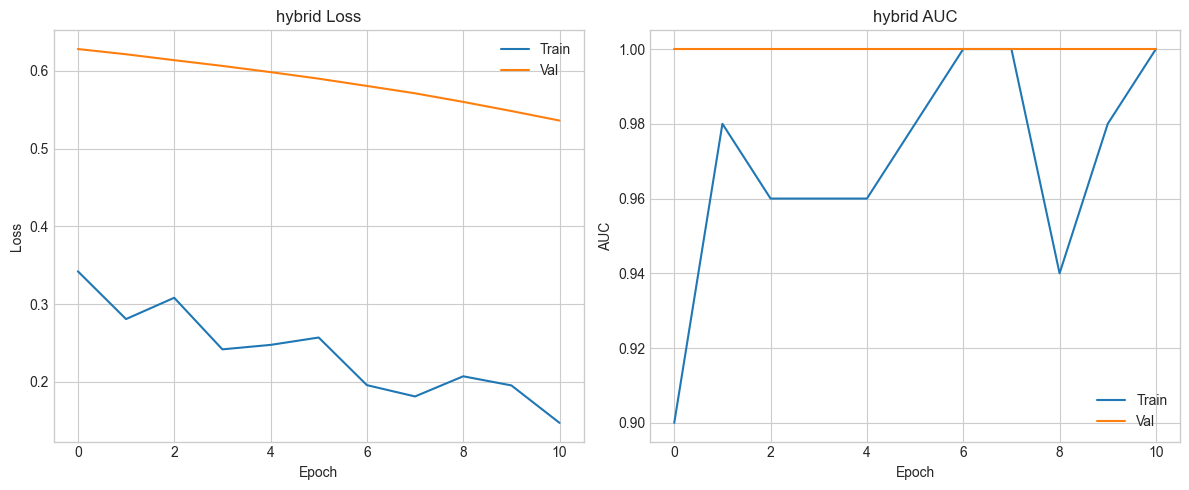

Training classical model...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0379 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0543 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0545 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3473 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0747 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0524 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3384 - learning_rate: 0.0010
Epoch 6/50
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

/Users/cassie/Documents/GSoC/.conda/lib/python3.9/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_1,loss,val_accuracy,val_auc_1,val_loss
  current = self.get_monitor_value(logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0598 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0434 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3284 - learning_rate: 0.0010
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0355 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3230 - learning_rate: 0.0010
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0366 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0402 - val_accuracy: 0.9800 - val_auc_1: 0.9630 - val_loss: 0.3152 - learning_rate: 0.0010
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - auc_1: 1.0000 

KeyError: 'val_auc'

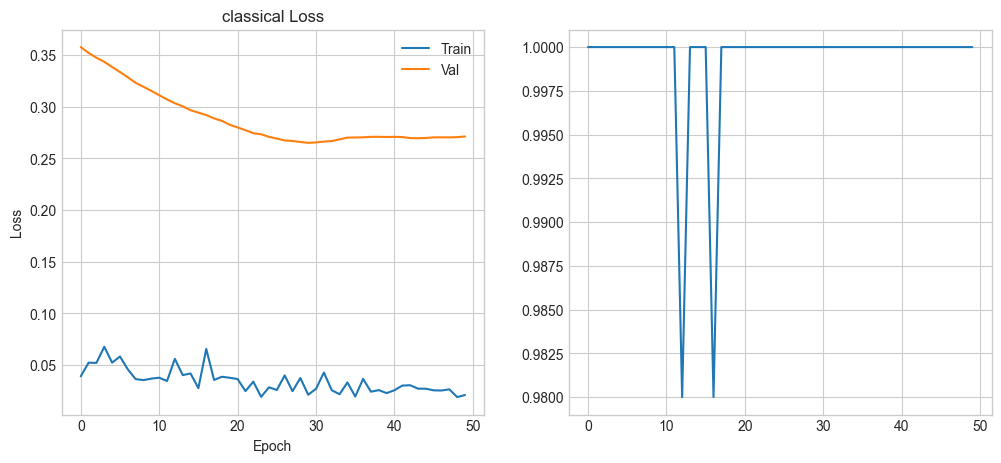

In [27]:
def train_model(model, X_train, y_train, X_test, y_test, model_name, class_weights=None):
    """Train and evaluate model with simplified output"""
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max'
    )
    
    # Learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    
    # Train model
    print(f"Training {model_name} model...")
    start_time = datetime.now()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, lr_scheduler],
        class_weight=class_weights,
        verbose=1
    )
    
    training_time = datetime.now() - start_time
    print(f"Training completed in {training_time}")
    
    # Plot simple training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_auc'], label='Val')
    plt.title(f'{model_name} AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{results_dir}/figures/{model_name}_history.png", dpi=300)
    plt.show()
    
    return history

# Train hybrid model
hybrid_history = train_model(
    hybrid_model,
    [X_train, quantum_train_features],
    y_train,
    [X_test, quantum_test_features],
    y_test,
    "hybrid",
    class_weight_dict
)

# Train classical model
classical_history = train_model(
    classical_model,
    X_train,
    y_train,
    X_test,
    y_test,
    "classical",
    class_weight_dict
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Hybrid Model Performance:
  Accuracy: 0.9800
  AUC:      1.0000
  F1 Score: 0.9778


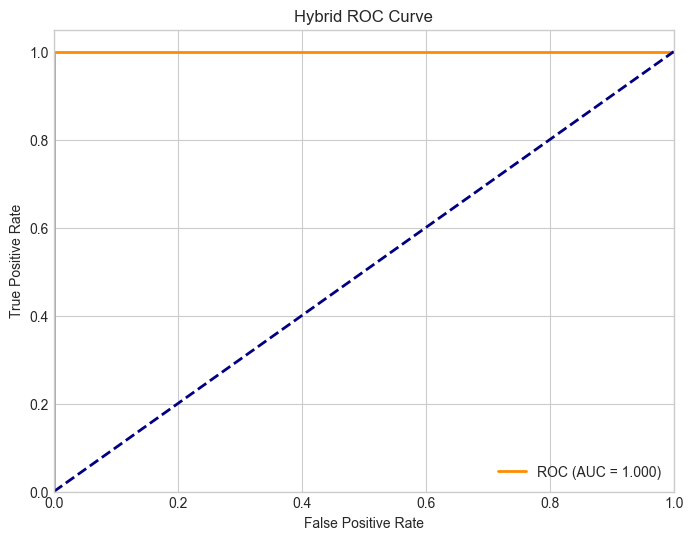

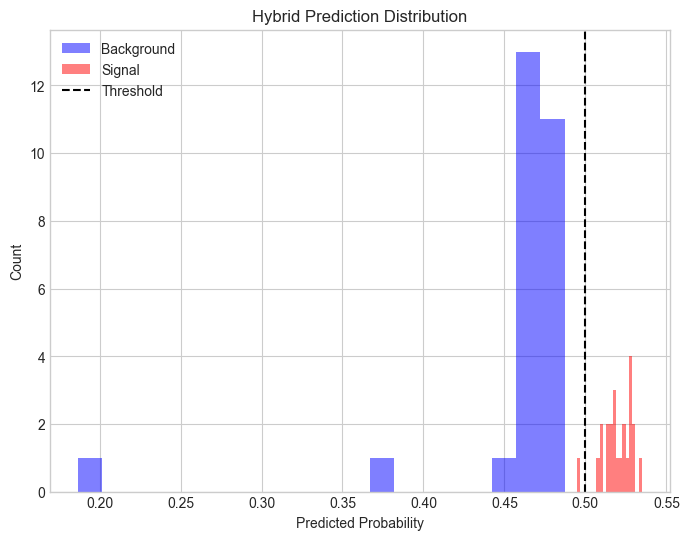

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x305cd4f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

Classical Model Performance:
  Accuracy: 0.9800
  AUC:      0.9630
  F1 Score: 0.9787


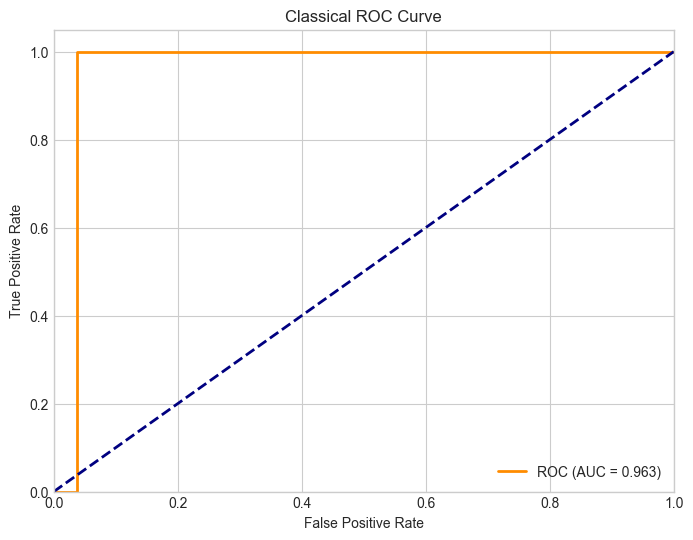

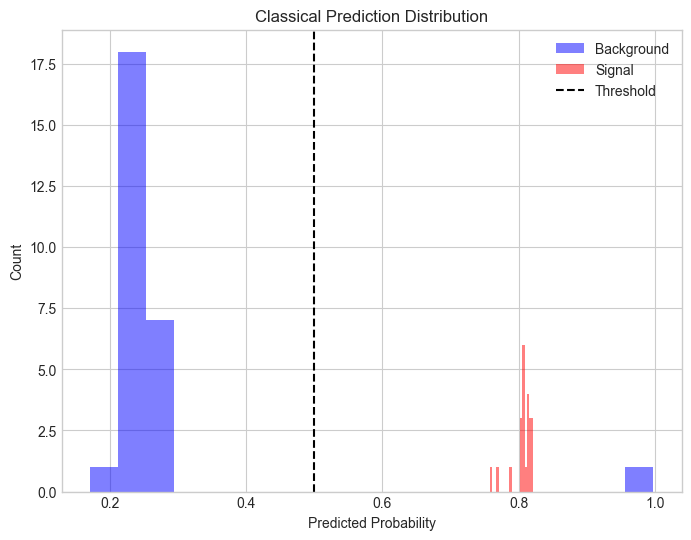

In [25]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model with simplified metrics and visualization"""
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(y_test, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_test, (y_pred > 0.5).astype(int))
    
    # Print metrics
    print(f"\n{model_name.capitalize()} Model Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC:      {roc_auc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    
    # Simple ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name.capitalize()} ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f"{results_dir}/figures/{model_name}_roc.png", dpi=300)
    plt.show()
    
    # Prediction distribution
    plt.figure(figsize=(8, 6))
    plt.hist(y_pred[y_test == 0], bins=20, alpha=0.5, label='Background', color='blue')
    plt.hist(y_pred[y_test == 1], bins=20, alpha=0.5, label='Signal', color='red')
    plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title(f'{model_name.capitalize()} Prediction Distribution')
    plt.legend()
    plt.savefig(f"{results_dir}/figures/{model_name}_pred_dist.png", dpi=300)
    plt.show()
    
    return {
        'accuracy': accuracy,
        'auc': roc_auc,
        'f1': f1
    }

# Evaluate models
hybrid_metrics = evaluate_model(
    hybrid_model,
    [X_test, quantum_test_features],
    y_test,
    "hybrid"
)

classical_metrics = evaluate_model(
    classical_model,
    X_test,
    y_test,
    "classical"
)

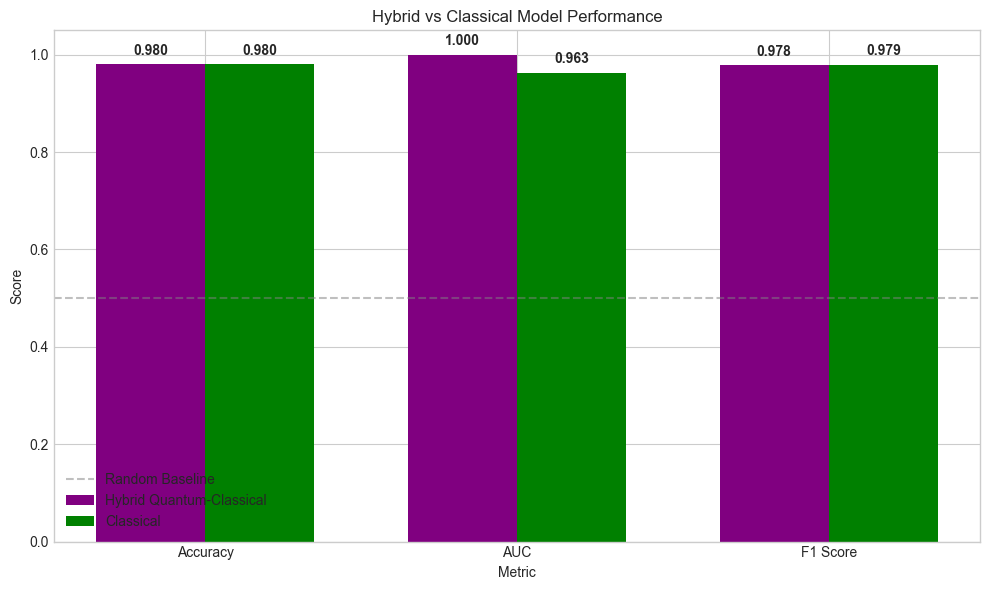


MODEL PERFORMANCE COMPARISON
Metric       Hybrid     Classical  Difference
--------------------------------------------------
Accuracy     0.9800     0.9800     +0.0000 (+0.0%)
AUC          1.0000     0.9630     +0.0370 (+3.8%)
F1 Score     0.9778     0.9787     -0.0009 (-0.1%)
Average improvement: +1.2%


In [28]:
def compare_models(hybrid_metrics, classical_metrics):
    """Compare hybrid and classical models with simple visualization"""
    # Calculate improvements
    metrics = ['Accuracy', 'AUC', 'F1 Score']
    hybrid_values = [hybrid_metrics['accuracy'], hybrid_metrics['auc'], hybrid_metrics['f1']]
    classical_values = [classical_metrics['accuracy'], classical_metrics['auc'], classical_metrics['f1']]
    
    # Create comparison bar chart
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, hybrid_values, width, label='Hybrid Quantum-Classical', color='purple')
    plt.bar(x + width/2, classical_values, width, label='Classical', color='green')
    
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Baseline')
    
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Hybrid vs Classical Model Performance')
    plt.xticks(x, metrics)
    plt.ylim(0, 1.05)
    plt.legend()
    
    # Add values on bars
    for i, v in enumerate(hybrid_values):
        plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    for i, v in enumerate(classical_values):
        plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{results_dir}/figures/model_comparison.png", dpi=300)
    plt.show()
    
    # Print comparison
    print("\n" + "="*50)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*50)
    print(f"{'Metric':<12} {'Hybrid':<10} {'Classical':<10} {'Difference':<10}")
    print("-"*50)
    
    for i, metric in enumerate(metrics):
        diff = hybrid_values[i] - classical_values[i]
        diff_pct = diff / max(classical_values[i], 0.001) * 100
        print(f"{metric:<12} {hybrid_values[i]:.4f}     {classical_values[i]:.4f}     {diff:+.4f} ({diff_pct:+.1f}%)")
    
    print("="*50)
    
    # Determine average improvement
    avg_diff_pct = np.mean([
        (hybrid_values[i] - classical_values[i]) / max(classical_values[i], 0.001) * 100
        for i in range(len(metrics))
    ])
    
    print(f"Average improvement: {avg_diff_pct:+.1f}%")

# Compare models
compare_models(hybrid_metrics, classical_metrics)

The Quantum Model showed slight advantage over classical one, maybe an icrease in the size of the dataset can further demonstrate quantum supremacy.